# **Submitted by:**<br>
**- Adir Hilvert **<br>
**- Ogen Drukerman **

# **Questions 1-3:** 

#### **Imports**

In [30]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import numpy as np
from math import sqrt
from sklearn.metrics import accuracy_score, plot_confusion_matrix
import matplotlib.pyplot as plt
import sympy as sp
import math
print(tf.__version__)

1.15.2


#### **Model definition**

In [75]:
def binary_encode(i, num_digits):
    return np.array([i >> d & 1 for d in range(num_digits)])
def fizz_buzz_encode(i):
    if   i % 15 == 0: return np.array([0, 0, 0, 1])
    elif i % 5  == 0: return np.array([0, 0, 1, 0])
    elif i % 3  == 0: return np.array([0, 1, 0, 0])
    else:             return np.array([1, 0, 0, 0])

NUM_DIGITS = 10
trX = np.array([binary_encode(i, NUM_DIGITS) for i in range(101, 2 ** NUM_DIGITS)])
trY = np.array([fizz_buzz_encode(i)          for i in range(101, 2 ** NUM_DIGITS)])

NUM_HIDDEN = 100
X = tf.placeholder("float", [None, NUM_DIGITS])
Y = tf.placeholder("float", [None, 4])

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

w_h = init_weights([NUM_DIGITS, NUM_HIDDEN])
w_o = init_weights([NUM_HIDDEN, 4])

def model(X, w_h, w_o):
    h = tf.nn.relu(tf.matmul(X, w_h))
    return tf.matmul(h, w_o)

py_x = model(X, w_h, w_o)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels =Y))
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
predict_op = tf.argmax(py_x, 1)

def fizz_buzz(i, prediction):
    return [str(i), "fizz", "buzz", "fizzbuzz"][prediction]

**Preparing test data (teX) & labels (actuals) - for binary representation**

In [32]:
numbers = np.arange(1, 101)
teX = np.transpose(binary_encode(numbers, NUM_DIGITS))
actuals = [fizz_buzz(i, fizz_buzz_encode(i).argmax()) for i in numbers]

**Next,the model will be trained (numbers 101-1024) & tested (1-100), lastly - the fizzbuzz output will be printed**

In [ ]:
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    for epoch in range(10000):
        p = np.random.permutation(range(len(trX)))
        trX, trY = trX[p], trY[p]
        BATCH_SIZE = 128
        for start in range(0, len(trX), BATCH_SIZE):
          end = start + BATCH_SIZE
          sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
        print(epoch, np.mean(np.argmax(trY, axis=1) ==
                              sess.run(predict_op, feed_dict={X: trX, Y: trY})))
#   Test the model
    teY = sess.run(predict_op, feed_dict={X: teX})
    output = np.vectorize(fizz_buzz)(numbers, teY)
    print(output)


#### **Post-Processing**

**Finding classification errors:**

In [34]:
# print the misclassified test predictions and actual test labels
# if no value is printed - accuracy should be 1

for i, (predicted, actual) in enumerate(zip(output, actuals)):
    if predicted != actual:
        print("{0} {1} {2}".format(i+1, predicted, actual))

21 21 fizz
32 fizz 32
81 81 fizz
93 93 fizz
100 100 buzz


**Evaluate Accuracy**

In [35]:
print(accuracy_score(actuals, output))

0.95


**Confusion Matrix**

In [36]:
# translating numbers 1 to 101 to the numeric target classes [1 - int,2 - fizz,3 - buzz,4 - fizzbuzz]
labels= np.array([fizz_buzz_encode(number).argmax() for number in numbers])

with tf.Session() as sess:
  confusion = tf.confusion_matrix(labels=labels, predictions=teY, num_classes=4)
  print(confusion.eval(session=sess))

[[52  1  0  0]
 [ 3 24  0  0]
 [ 1  0 13  0]
 [ 0  0  0  6]]


# **Question 4:**

**Executing the algorithm 10 times**

In [37]:
accuracy_arr = []
with tf.Session() as sess:
    for i in range(10):
      tf.initialize_all_variables().run()
      for epoch in range(10000):
          p = np.random.permutation(range(len(trX)))
          trX, trY = trX[p], trY[p]
          BATCH_SIZE = 128
          for start in range(0, len(trX), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
  #   Test the model
      teY = sess.run(predict_op, feed_dict={X: teX})
      output = np.vectorize(fizz_buzz)(numbers, teY)
      accuracy_arr.append(accuracy_score(actuals, output))

**Displaying Accuracy values of 10 iterations**

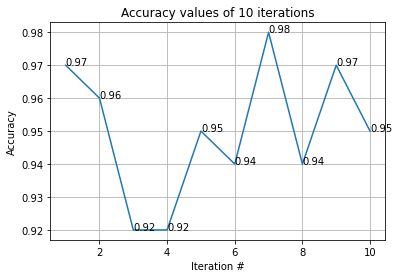

In [38]:
iterations = np.arange(1, 11)
fig, ax = plt.subplots()
ax.plot(iterations, accuracy_arr)
for a,b in zip(iterations, accuracy_arr): 
    plt.text(a, b, str(b))
ax.set(xlabel='Iteration #', ylabel='Accuracy',
       title='Accuracy values of 10 iterations')
ax.grid()
plt.show()

# **Question 5:**

**Each number is encoded in array of size 100 where index will indicate the prime factor and the value will indicate the multiplicity.
All factors largers than 100 will be assigned to the last bucket of the encoding array**

**Defining primes encoding function**

In [135]:
TRAINING_SIZE = 1024
ENCODING_SIZE = 100

def prime_encode(i):
    encoded_array  = np.zeros(ENCODING_SIZE)
    factors_dict=sp.factorint(i) 
    factors = list(factors_dict.keys())
    multiplicities = list(factors_dict.values())
    for j in range(len(factors)):
      if factors[j] > ENCODING_SIZE:
        encoded_array[len(encoded_array)-1] = multiplicities[j]
      else:  
        encoded_array[factors[j]] = multiplicities[j]
    return encoded_array

**Preparing primes test data**

In [136]:
# primes test set
teX = [prime_encode(num) for num in numbers]
teX = np.array(teX)

**Updating input & weights vectors according to the input representation (size 100)**

In [137]:
#setting training set
trX = np.array([prime_encode(i) for i in range(101, TRAINING_SIZE)])
trY = np.array([fizz_buzz_encode(i) for i in range(101, TRAINING_SIZE)])

# placeholder update according to new input encoding
X = tf.placeholder("float", [None, ENCODING_SIZE])
Y = tf.placeholder("float", [None, 4])

# weights definition update
w_h_1 = init_weights([ENCODING_SIZE, NUM_HIDDEN])
w_o_1 = init_weights([NUM_HIDDEN, 4])

# model Update with new input & weights
py_x = model(X, w_h_1, w_o_1)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels =Y))
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost)
predict_op = tf.argmax(py_x, 1)

**Training and testing the model (output printed)**



In [ ]:
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    for epoch in range(10000):
        p = np.random.permutation(range(len(trX)))
        trX, trY = trX[p], trY[p]
        BATCH_SIZE = 128
        for start in range(0, len(trX), BATCH_SIZE):
          end = start + BATCH_SIZE
          sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
        print(epoch, np.mean(np.argmax(trY, axis=1) ==
                              sess.run(predict_op, feed_dict={X: trX, Y: trY})))
#   Test the model
    teY = sess.run(predict_op, feed_dict={X: teX})
    output = np.vectorize(fizz_buzz)(numbers, teY)
    print(output)

In [139]:
# print the misclassified test predictions and actual test labels
# if no value is printed - accuracy should be 1
for i, (predicted, actual) in enumerate(zip(output, actuals)):
    if predicted != actual:
        print("{0} {1} {2}".format(i+1, predicted, actual))

**Reporting Accuracy**

In [140]:
print(accuracy_score(actuals, output))

1.0


**Executing the Prime-based algorithm 10 times:**

In [141]:
accuracy_arr = []
with tf.Session() as sess:
    for i in range(10):
      tf.initialize_all_variables().run()
      for epoch in range(10000):
          p = np.random.permutation(range(len(trX)))
          trX, trY = trX[p], trY[p]
          BATCH_SIZE = 128
          for start in range(0, len(trX), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
  #   Test the model
      teY = sess.run(predict_op, feed_dict={X: teX})
      output = np.vectorize(fizz_buzz)(numbers, teY)
      accuracy_arr.append(accuracy_score(actuals, output))

**Displaying results in a chart**

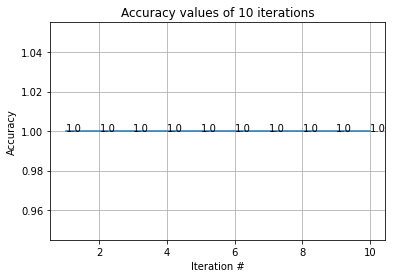

In [142]:
iterations = np.arange(1, 11)
fig, ax = plt.subplots()
ax.plot(iterations, accuracy_arr)
for a,b in zip(iterations, accuracy_arr): 
    plt.text(a, b, str(b))
ax.set(xlabel='Iteration #', ylabel='Accuracy',
       title='Accuracy values of 10 iterations')
ax.grid()
plt.show()

**Conclusion: The Prime-based algorithm outperforms the binary-based**

# **Question 6:**

**Finding smallest network that yields perfect results - 
after trial and error, we show that a hidden layer of size 9 is sufficient for a perfect result**

**Adjusting hidden layer size to 9 and weights accordingly:**

In [144]:
NUM_HIDDEN = 9
#updating weights vectors
w_h_Q6 = init_weights([ENCODING_SIZE, NUM_HIDDEN])
w_o_Q6 = init_weights([NUM_HIDDEN, 4])

# model Update with new weights
py_x = model(X, w_h_Q6, w_o_Q6)

**Executing the model 10 times to verify accuracy stability**

In [146]:
accuracy_arr = []
with tf.Session() as sess:
    for i in range(10):
      tf.initialize_all_variables().run()
      for epoch in range(10000):
          p = np.random.permutation(range(len(trX)))
          trX, trY = trX[p], trY[p]
          BATCH_SIZE = 128
          for start in range(0, len(trX), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
  #   Test the model
      teY = sess.run(predict_op, feed_dict={X: teX})
      output = np.vectorize(fizz_buzz)(numbers, teY)
      accuracy_arr.append(accuracy_score(actuals, output))

**Displaying results in a chart**

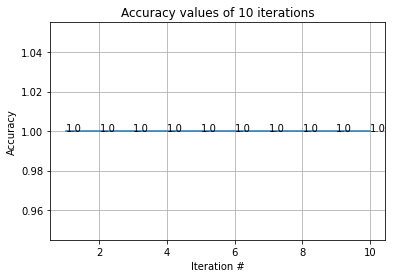

In [147]:
iterations = np.arange(1, 11)
fig, ax = plt.subplots()
ax.plot(iterations, accuracy_arr)
for a,b in zip(iterations, accuracy_arr): 
    plt.text(a, b, str(b))
ax.set(xlabel='Iteration #', ylabel='Accuracy',
       title='Accuracy values of 10 iterations')
ax.grid()
plt.show()

# **Question 7:**

**Defining classfication function from prime representation input to fizzbuz**

In [148]:
def convert_prime_arr_to_strInt(encoded_arr):
  result = 1
  for i in range(len(encoded_arr)):
    if encoded_arr[i] != 0:
      result = result * i**encoded_arr[i]
  return(str(int(result)))

def fizzbuzz_primes_classify(encoded_arr):
  if np.array_equal(encoded_arr,np.zeros(ENCODING_SIZE)):
    return 1
  for i in range(1,len(encoded_arr)):
    if encoded_arr[3] != 0 and encoded_arr[5] != 0:
      return ("fizzbuzz")
    elif encoded_arr[5] != 0:
      return ("buzz")
    elif encoded_arr[3] != 0:
      return("fizz")
    else:
      return(convert_prime_arr_to_strInt(encoded_arr))


**Classifier accuracy:**

In [149]:
output_q7 = np.array([fizzbuzz_primes_classify(elm) for elm in teX] )
accuracy_score(actuals, output_q7)

1.0

**Classfication results from 1 to 100:**

In [150]:
output_q7

array(['1', '2', 'fizz', '4', 'buzz', 'fizz', '7', '8', 'fizz', 'buzz',
       '11', 'fizz', '13', '14', 'fizzbuzz', '16', '17', 'fizz', '19',
       'buzz', 'fizz', '22', '23', 'fizz', 'buzz', '26', 'fizz', '28',
       '29', 'fizzbuzz', '31', '32', 'fizz', '34', 'buzz', 'fizz', '37',
       '38', 'fizz', 'buzz', '41', 'fizz', '43', '44', 'fizzbuzz', '46',
       '47', 'fizz', '49', 'buzz', 'fizz', '52', '53', 'fizz', 'buzz',
       '56', 'fizz', '58', '59', 'fizzbuzz', '61', '62', 'fizz', '64',
       'buzz', 'fizz', '67', '68', 'fizz', 'buzz', '71', 'fizz', '73',
       '74', 'fizzbuzz', '76', '77', 'fizz', '79', 'buzz', 'fizz', '82',
       '83', 'fizz', 'buzz', '86', 'fizz', '88', '89', 'fizzbuzz', '91',
       '92', 'fizz', '94', 'buzz', 'fizz', '97', '98', 'fizz', 'buzz'],
      dtype='<U21')

# **Question 8:**


**Creating weights vectors which will yield a perfect score :<br>**
(we will set the weights in such way that matrices multiplication will zero all values except values<br> that correspond to the 3 & 5 prime factors in the input vector)

In [151]:
w_h_Q8 = np.full((ENCODING_SIZE,9),0,dtype = np.float32)
w_o_Q8 = np.full((9,4),0,dtype = np.float32)

class_none  = 0
class_fizz = 1
class_buzz = 2
class_fizzbuzz = 3

w_h_Q8[3,0] = 1
w_h_Q8[5,1] = 1
w_h_Q8[:,2] = 1

w_o_Q8[2,class_none] = 0.0001
w_o_Q8[0,class_fizz] = 1
w_o_Q8[1,class_buzz] = 1
w_o_Q8[0,class_fizzbuzz] = 0.999
w_o_Q8[1,class_fizzbuzz] = 0.999



**Executing the model with the hardcoded weights:**

In [153]:
with tf.Session() as sess:
  py_x = model(X, w_h_Q8, w_o_Q8)
  predict_op2 = tf.argmax(py_x, 1)
  
  teY = sess.run(predict_op2, feed_dict={X: teX})
  output = np.vectorize(fizz_buzz)(numbers, teY)

**Reporting the Accuracy:**

In [154]:
for i, (predicted, actual) in enumerate(zip(output, actuals)):
    if predicted != actual:
        print("{0} {1} {2}".format(i+1, predicted, actual))
accuracy_score(actuals, output)

1.0

# **Question 9:**

In [156]:
class Neuron:

  def __init__(self, quantity=10, std_dev=0.1):
    self.qt = quantity
    self.w = np.random.normal(0,std_dev,(1,self.qt))
    self.b = np.random.normal(0,0.1,1) #init random
    self.output = 0
    self.innet = 0
    
  def sigmoid(self, x):
    return 1 / (1 + math.exp(-x))

  def sigmoid_derivative(self, x):
    return (self.sigmoid(x)*(1-self.sigmoid(x)))
  
  def forward(self, input):
    input = np.reshape(input,(len(input),1))
    self.innet = input
    self.output = self.sigmoid(np.dot(self.w, input))
    return self.output

  def backward(self, error):
    dw = np.dot(self.innet, error * self.sigmoid_derivative(self.output))
    dx = np.dot(self.w.T, error * self.sigmoid_derivative(self.output))
    db = error * self.sigmoid_derivative(self.output)
    return (db, dw, dx)

  def ModifyWb(self, mdf_dw, mdf_db):
    mdf_dw_T = mdf_dw.T
    self.w = self.w + mdf_dw_T
    self.b = self.b + mdf_db

In [157]:
n = Neuron(10,0.1)
x = np.random.normal(0,0.1,10)  
res = n.forward(x)
db,dw,dx = n.backward(0.3) 

print("first printout\n")
########################
print("res =",res)
print("db =",db)
print("dw =\n",dw)
print("dx =\n",dx)

x = np.ones(10)
eta = 1.0e-6
n.ModifyWb(-eta*dw,-eta*db) 
res = n.forward(x)
db,dw,dx = n.backward(0.3)

print("\nsecond printout\n")
########################
print("res =",res)
print("db =",db)
print("dw =\n",dw)
print("dx =\n",dx)

first printout

res = 0.4956990930510003
db = 0.07057510981182813
dw =
 [[ 0.008585  ]
 [ 0.01017661]
 [-0.00870203]
 [ 0.0035293 ]
 [-0.00360819]
 [-0.00350787]
 [ 0.00693253]
 [-0.00094887]
 [-0.0070628 ]
 [ 0.01061256]]
dx =
 [[ 0.0036186 ]
 [-0.00521048]
 [ 0.01233812]
 [-0.0091139 ]
 [-0.0083911 ]
 [ 0.00060514]
 [ 0.00022298]
 [ 0.0012219 ]
 [-0.00301857]
 [ 0.00244437]]

second printout

res = 0.481294875571229
db = 0.07081900467432133
dw =
 [[0.070819]
 [0.070819]
 [0.070819]
 [0.070819]
 [0.070819]
 [0.070819]
 [0.070819]
 [0.070819]
 [0.070819]
 [0.070819]]
dx =
 [[ 0.00363111]
 [-0.00522848]
 [ 0.01238076]
 [-0.0091454 ]
 [-0.0084201 ]
 [ 0.00060723]
 [ 0.00022375]
 [ 0.00122612]
 [-0.003029  ]
 [ 0.00245282]]
